In [15]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv
from scipy.sparse import csc_matrix

Heatequation

$\partial_t T(x,t) = \alpha \frac{d^2 T}{dx^2}(x,t)$ 

$T_0 (0) = 273$

$T(t,0) = 273$

$T(t,1) = 400$

In [16]:
class Solution:
    def __init__(self, T0, Tleft, Tright, Ntime, Nspace, dx) -> None:
        self.solution = np.zeros((Ntime, Nspace))
        self.Ntime = Ntime
        self.Nspace = Nspace
        self.Tleft = Tleft
        self.Tright = Tright
        self.solution[0,:] = T0
        self.timestep = 0
        self.timesteps = []
        self.dx = dx
        self.applyRB()


    def newTime(self, dt):
        self.timesteps.append(dt)
        self.timestep = self.timestep + 1
        try:
            self.solution[self.timestep, :] = self.solution[self.timestep-1, :]
        except IndexError:
            print("maximum timestep reached")
        self.applyRB()

    def applyRB(self):
        self.solution[self.timestep, 0] = self.Tleft
        self.solution[self.timestep, -1] = self.Tright

    def getVal(self, spaceiter):
        if spaceiter < 0:
            spaceiter = 0
        elif spaceiter > self.Nspace-1:
            spaceiter = self.Nspace-1
        return self.solution[self.timestep, spaceiter]

    def getPreVal(self, spaceiter):
        if spaceiter < 0:
            spaceiter = 0
        elif spaceiter > self.Nspace-1:
            spaceiter = self.Nspace-1
        return self.solution[self.timestep-1, spaceiter]

    def setVal(self, spaceiter, value):
        if spaceiter <= 0:
            pass
        elif spaceiter >= self.Nspace-1:
            pass
        else:
            self.solution[self.timestep, spaceiter] = value

    def getTimestep(self):
        return self.solution[self.timestep, :]

    def getPreTimestep(self):
        return self.solution[self.timestep-1, :]

In [17]:
# numerical Definitions:
Ntime = 50
Nspace = 200
dx = 1
dt_target = 2


# physical parametrization
T1 = 273
T2 = 400
K = 0.1
sol = Solution(T1, T1, T2, Ntime, Nspace, dx)
sol_temp = Solution(T1, T1, T2, 2, Nspace, dx)

# newton settings 
damping = 0.5
max_iter = 100
tol = 1e-10

# Discretization Scheme:

$\frac{T^{n+1}_i-T^n_i}{\Delta t} = \alpha \frac{T^{n+1}_{i-1}-2T^{n+1}_i + T^{n+1}_{i+1}}{\Delta x^2}$

define F such
 
$F(T) = 0$

In [18]:
def F(solution, dt, dTleft=0, dTmiddle=0, dTright=0):
    R = []
    for spaceiter in range(0, solution.Nspace):
        Tnewleft = solution.getVal(spaceiter-1) + dTleft
        Tnewright = solution.getVal(spaceiter+1) + dTright
        Tnewmiddle = solution.getVal(spaceiter) + dTmiddle
        Toldmiddle = solution.getPreVal(spaceiter)
        R.append(K*dt * (Tnewleft-2*Tnewmiddle+Tnewright)/(solution.dx**2) - Tnewmiddle+Toldmiddle)
    return np.matrix(R).transpose()
    

In [19]:
np.array([[1,2],[3,4]])[1,0]


3

In [20]:
def JF(solution, dt):
    dT = 1e-6
    J = np.zeros((solution.Nspace,solution.Nspace))
    for i in range(0, solution.Nspace):
        for j in range(0, solution.Nspace):
            if (j == i-1):
                J[i,j] = (F(solution, dt, dTleft=dT)[i] - F(solution, dt, dTleft=0.0)[i] ) / dT
            elif j == i:
                J[i,j] = (F(solution, dt, dTmiddle=dT)[i] - F(solution, dt, dTmiddle=0.0)[i] ) / dT
            elif (j == i + 1):
                J[i,j] = (F(solution, dt, dTright=dT)[i] - F(solution, dt, dTright=0.0)[i] ) / dT
            else:
                 J[i,j] = 0.0
    return J

In [21]:
def dFdt(solution):
    dRdt = []
    for spaceiter in range(0, solution.Nspace):
        Tnewleft = solution.getVal(spaceiter-1)
        Tnewright = solution.getVal(spaceiter+1)
        Tnewmiddle = solution.getVal(spaceiter)
        dRdt.append(K * (Tnewleft-2*Tnewmiddle+Tnewright)/(solution.dx**2))
    return np.matrix(dRdt).transpose()

In [22]:
def is_within_neighborhood(solution, dt):
    restol = np.sqrt(np.sqrt(tol))
    print(f"Neighborhooodcheck: residual {np.linalg.norm(F(solution, dt))}, restol: {restol}")
    if np.linalg.norm(F(solution, dt)) < restol:
        print("within neighborhood")
        return True
    else:
        print("out of neighborhood")
        return False

In [23]:
C = np.sqrt(1e-16)
C = np.max([C, 1/np.linalg.norm(dFdt(sol))])

In [24]:
C

0.05567769930602737

In [25]:
def compute_tangent(solution, dt):
    print("comput tangent")
    C = np.sqrt(1e-16)
    C = np.max([C, 1/np.linalg.norm(dFdt(solution))])
    Jinv = inv(csc_matrix(JF(solution, dt))).todense()
    delta_T = -C * np.matmul(Jinv, dFdt(solution))
    delta_t = C
    delta = np.concatenate((delta_T, np.matrix([delta_t])), axis=0)
    delta = delta/np.linalg.norm(delta)
    return delta

In [26]:
def tangent_step_length(solution, delta, dt):
    sol_temp = Solution(solution.Tleft, solution.Tleft, solution.Tright, 2, solution.Nspace, solution.dx)
    sol_temp.timestep = 1
    sol_temp.solution = np.concatenate(([copy.deepcopy(solution.getPreTimestep())], [copy.deepcopy(solution.getTimestep())]), axis=0)
    maxiter = 15
    tmin = 1e-8 # CFL 1
    tmax = 1.e-1 # CFL 10 
    alpha_min = tmin / delta[solution.Nspace, 0]
    alpha_max = tmax / delta[solution.Nspace, 0]
    Delta = (alpha_max-alpha_min)/maxiter
    converged = False
    alpha = alpha_max
    print(f"initial alpha: {alpha}")
    it = 0
    while ((it < maxiter) and (converged is False)):
        for spaceiter in range(0, solution.Nspace):
            sol_temp.setVal(spaceiter, solution.getVal(spaceiter) + alpha * delta[spaceiter,0])
        deltatprime = dt + alpha * delta[solution.Nspace,0]
        if is_within_neighborhood(sol_temp, deltatprime) is True:
            converged = True
            print(f"alpha converged")
        alpha = alpha - Delta
        it = it +1
        print(f"reduce alpha: {alpha}")    
    return alpha



In [27]:
for i in range(0, Ntime-1):
    error = 9e9
    print(f"target time t = {i*dt_target}")
    sol.newTime(dt_target)
    niter = 0
    dt = 0

    while ((dt < dt_target) and (niter <= max_iter)):
        print(f"check timestep start of loop {sol.timestep}")
        print(f"niter {niter}")
        delta = compute_tangent(sol, dt)
        alpha = tangent_step_length(sol, delta, dt)
        sol_temp = Solution(sol.Tleft, sol.Tleft, sol.Tright, 2, sol.Nspace, sol.dx)
        sol_temp.timestep = 1
        sol_temp.solution = np.concatenate(([copy.deepcopy(sol.getPreTimestep())], [copy.deepcopy(sol.getTimestep())]), axis=0)
        for spaceiter in range(0, sol.Nspace):
            sol_temp.setVal(spaceiter, sol_temp.getVal(spaceiter) + alpha * delta[spaceiter,0])
        dt2 = alpha * delta[Nspace,0]
        print(f"suggest dt < dt_target: {dt2} niter:  {niter}")
        niter = niter + 1
        if is_within_neighborhood(sol_temp, dt2) is True:
            for spaceiter in range(0, sol.Nspace):
                sol.setVal(spaceiter, sol_temp.getVal(spaceiter))
            sol.timesteps[-1] = dt2
            dt = dt2
            print(f"accept timestep {sol.timestep}")
            sol.newTime(dt)
        else:
            print("outside neighborhood, try newton correction")
            # newton step
            newtoniter = 0
            while is_within_neighborhood(sol, dt) is False:
                print(f"newton correction iteration {newtoniter}")
                J = JF(sol, dt)
                f = F(sol, dt)
                Jinv = inv(csc_matrix(J)).todense()
                newton_step_solution =  np.matrix(sol.getTimestep().transpose()).transpose() - damping * np.matmul(Jinv,f)
                for spaceiter in range(0, sol.Nspace):
                    sol.setVal(spaceiter, newton_step_solution[spaceiter])
                newtoniter = newtoniter + 1
            niter = niter + newtoniter
    # newton solver
    newtoniter = 0
    while ((error > tol) and (niter <= max_iter)):   
        dx_pre = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
        J = JF(sol, dt)
        f = F(sol, dt)
        newton_step_solution = sol.getTimestep() - damping * np.matmul(np.linalg.inv(J), f)
        for spaceiter in range(0, sol.Nspace):
            sol.setVal(spaceiter, newton_step_solution[spaceiter])
        dx_post = np.sum( np.abs( sol.getTimestep()-sol.getPreTimestep() ))
        error = np.abs(dx_post-dx_pre)
        newtoniter = newtoniter + 1
        print(f"Newton iteration {newtoniter}: error: {error} tol: {tol}")
    niter = niter + newtoniter


target time t = 0
check timestep start of loop 1
niter 0
comput tangent


initial alpha: 1.79883295952924
Neighborhooodcheck: residual 1.257620666213111, restol: 0.0031622776601683794
out of neighborhood
reduce alpha: 1.6789107742195104
Neighborhooodcheck: residual 1.174530772919803, restol: 0.0031622776601683794
out of neighborhood
reduce alpha: 1.5589885889097808
Neighborhooodcheck: residual 1.0913360399495013, restol: 0.0031622776601683794
out of neighborhood
reduce alpha: 1.4390664036000511
Neighborhooodcheck: residual 1.0080358826755467, restol: 0.0031622776601683794
out of neighborhood
reduce alpha: 1.3191442182903215
Neighborhooodcheck: residual 0.9246297179553151, restol: 0.0031622776601683794
out of neighborhood
reduce alpha: 1.1992220329805918
Neighborhooodcheck: residual 0.8411169641322994, restol: 0.0031622776601683794
out of neighborhood
reduce alpha: 1.0792998476708622
Neighborhooodcheck: residual 0.757497041038018, restol: 0.0031622776601683794
out of neighborhood
reduce alpha: 0.9593776623611325
Neighborhooodcheck: residual 0.6737693699936975

IndexError: index 50 is out of bounds for axis 0 with size 50

In [28]:
sol.solution[-1]

array([273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.  

In [ ]:
sol.solution[49]

array([273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.        ,
       273.        , 273.        , 273.        , 273.  

IndexError: index 25 is out of bounds for axis 0 with size 3

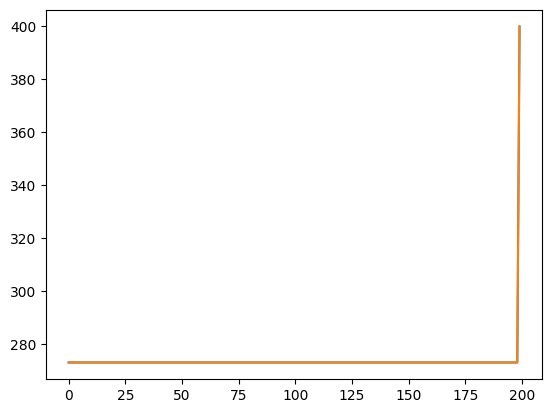

In [ ]:
timesteps = [0,2,25,50,75,100, 150, 199]
for it in timesteps:
    plt.plot(sol.solution[it,:], label=f"t = {dt*it} s")
plt.legend()
plt.xlabel("x / m")
plt.ylabel("T / K")